In [3]:
import torch
import torchvision
import torchvision.transforms as tt
import cv2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd

In [4]:
def get_default_device():
  if torch.cuda.is_available():
      return torch.device('cuda')
  else:
      return torch.device('cpu')
device=get_default_device()

In [5]:
model=torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(device)

C:\Users\KIIT\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\KIIT\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
num_classes = 2  
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [7]:
state_dict=torch.load('./weights/model1.pt',map_location='cpu')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [8]:
test_tfms=tt.ToTensor()

In [9]:
df=pd.DataFrame(columns=['image_id','PredictionString'])

def add_coordinates(image_id, coordinates,scores):
    global df
    x1, y1,x2,y2 = coordinates
    prediction_string=f'{x1} {y1} {x2} {y2} {scores}'
    df = pd.concat([df, pd.DataFrame({'image_id': [image_id], 'PredictionString': [prediction_string]})],ignore_index=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

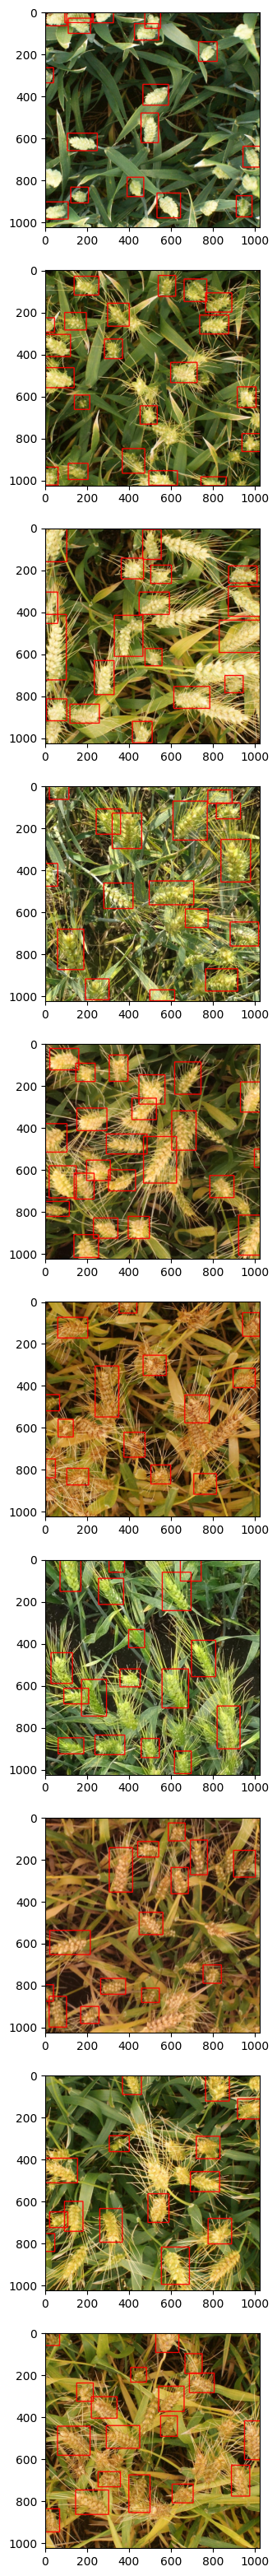

In [10]:
fig,ax=plt.subplots(10,1,figsize=(60,40))
i=0
model.eval()
for image in os.listdir('./data/'):
    id=image.replace(".jpg","")
    img=Image.open('./data/'+image)
    img_tensor=test_tfms(img)
    outputs=model(img_tensor.unsqueeze(0))
    boxes=outputs[0]['boxes'].detach().cpu().numpy().astype(np.int32)
    scores=outputs[0]['scores'].detach().cpu().numpy().astype(np.float32)
    image=img_tensor.permute(1,2,0).cpu().numpy().copy()
    indices=cv2.dnn.NMSBoxes(boxes,outputs[0]['scores'].detach().cpu().numpy().astype(np.float32),score_threshold=0.3, nms_threshold=0.4)
    for c in indices:
        add_coordinates(id,boxes[c],scores[c])
        x1,y1,x2,y2=boxes[c]
        cv2.rectangle(image,(x1,y1),(x2,y2),(255,0,0),3)
    ax[i].imshow(image)
    i=i+1

In [11]:
df

,image_id,PredictionString
0,2fd875eaa,105 577 247 660 0.9945669174194336
1,2fd875eaa,389 786 468 878 0.9918553829193115
2,2fd875eaa,464 345 586 444 0.9897547364234924
3,2fd875eaa,531 861 643 979 0.9895840287208557
4,2fd875eaa,908 874 983 974 0.9878402352333069
...,...,...
167,f5a1f0358,548 396 628 493 0.8758513331413269
168,f5a1f0358,525 0 635 95 0.8155717253684998
169,f5a1f0358,251 661 357 733 0.615401029586792
170,f5a1f0358,0 1 68 62 0.6038659811019897


In [12]:
df.to_csv('submission.csv',index=False)

# Anchor Boxes Visalization

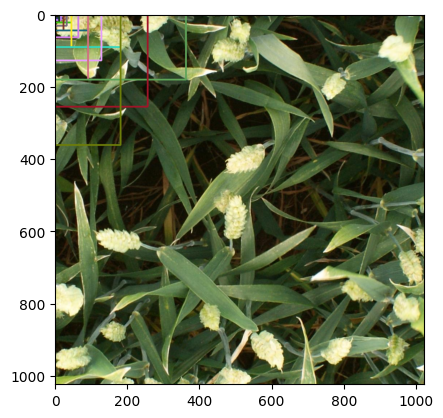

In [32]:
path='./data/2fd875eaa.jpg'
img=cv2.imread(path)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_tensor=test_tfms(img)
with torch.no_grad():
    model.eval()
    features=model.backbone(img_tensor)
    anchor_generator = model.rpn.anchor_generator
    anchor_sizes=anchor_generator.sizes
    anchor_ratios=anchor_generator.aspect_ratios
    anchor_boxes = anchor_generator.generate_anchors(anchor_sizes,anchor_ratios)
    anchor_boxes=anchor_boxes.detach().cpu().numpy().astype(np.int32)

for anchor in anchor_boxes:
    x1,y1,x2,y2=anchor
    color=np.random.randint(0,255,size=3).tolist()
    cv2.rectangle(img,(x1,y1),(x2,y2),color,3)
plt.imshow(img)